# Main notebook for generating models analysis

In [7]:
%matplotlib inline

## Dataset loading
So far, a single source dataset is used

In [8]:
#% Imports
import pandas as pd

#% Data import
#% engine=python because C engine has an error with a character in the middle of
## the file. May be slower but works.

df = pd.read_csv('../Datasets/macdonalds_for_guillaume.csv', engine='python')

In [9]:
#% Check data structure
df

Unnamed: 0                                               text  neg_pi
0               0   McDonald 's is trash, in this case I mean lit...       1
1               1  Here's What Eating Only  McDonald 's for 10 Da...       1
2               2   mcdonald 's can most definitely be good rn ev...       1
3               3  Nothing motivates my new diet than getting a p...       1
4               4  How does this  McDonald 's not have any burger...       1
...           ...                                                ...     ...
23097       23097  Both of the  McDonald 's in Hays could win an ...       0
23098       23098  Maintenance Person -  McDonald 's - Everett, W...       0
23099       23099  Check out the 38 latest openings at Love's Tra...       0
23100       23100  New on GT: Positives, Needs and Hopes.... Arse...       0
23101       23101  You better BELIEVE I got myself fucking  McDon...       0

[23102 rows x 3 columns]

In [15]:
df['neg_pi'].sum() / df.shape[0] * 100

6.445329408709203

In [17]:
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

texts = df['text']

y = df['neg_pi'].values

#% Fit tokenizer
tokenizer = Tokenizer(num_words=None, lower=True, split=' ')
tokenizer.fit_on_texts(texts)

#% For index/word retrieval
word_to_index = tokenizer.word_index
index_to_word = {word_to_index[v]:v for v in word_to_index}

#% Tokenize data
texts_tokenized = tokenizer.texts_to_sequences(texts)

#% Histogram of lengths
lengths = np.array(sorted([len(entry) for entry in texts_tokenized]))

print('Vocabulary size :', len(tokenizer.word_index) + 1)
print('Max len :', max(lengths))

#% sequence len
sequence_length = int(lengths.mean() + 3 * lengths.std())
print('Sequence len :', sequence_length)

plt.hist(lengths, bins=range(max(lengths)+1))
plt.axvline(x=sequence_length, color='r')
plt.xlabel('length')
plt.title(r'Histogram of lengths')
plt.savefig('../Models/histogram_lengths.png')
plt.show()

#% Pad at max length
X = pad_sequences(texts_tokenized, maxlen=sequence_length)

Vocabulary size : 42239
Max len : 88
Sequence len : 61


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 18481 samples, validate on 4621 samples
Epoch 1/50
18481/18481 [==============================] - 18s 957us/step - loss: 0.2963 - accuracy: 0.9298 - val_loss: 0.2321 - val_accuracy: 0.9355
Epoch 2/50
18481/18481 [==============================] - 1s 43us/step - loss: 0.1696 - accuracy: 0.9432 - val_loss: 0.1331 - val_accuracy: 0.9483
Epoch 3/50
18481/18481 [==============================] - 1s 40us/step - loss: 0.0911 - accuracy: 0.9646 - val_loss: 0.1256 - val_accuracy: 0.9602
Epoch 4/50
18481/18481 [==============================] - 1s 42us/step - loss: 0.0663 - accuracy: 0.9758 - val_loss: 0.1253 - val_accuracy: 0.9606
Epoch 5/50
18481/18481 [==============================] - 1s 42us/step - loss: 0.0491 - accuracy: 0.9829 - val_loss: 0.1357 - val_accuracy: 0.9541
Epoch 6/50
18481/18481 [==============================] - 1s 42us/step - loss: 0.0397 - accuracy: 0.9866 - val_loss: 0.

Epoch 4/50
18483/18483 [==============================] - 10s 535us/step - loss: 0.0643 - accuracy: 0.9752 - val_loss: 0.1267 - val_accuracy: 0.9543
Epoch 5/50
18483/18483 [==============================] - 9s 508us/step - loss: 0.0506 - accuracy: 0.9817 - val_loss: 0.1655 - val_accuracy: 0.9502
Epoch 6/50
18483/18483 [==============================] - 10s 525us/step - loss: 0.0410 - accuracy: 0.9846 - val_loss: 0.1462 - val_accuracy: 0.9548
Epoch 7/50
18483/18483 [==============================] - 9s 509us/step - loss: 0.0326 - accuracy: 0.9885 - val_loss: 0.1846 - val_accuracy: 0.9545
Epoch 8/50
18483/18483 [==============================] - 10s 535us/step - loss: 0.0283 - accuracy: 0.9909 - val_loss: 0.1772 - val_accuracy: 0.9487
Classification report:               precision    recall  f1-score   support

           0       0.97      0.98      0.98      4322
           1       0.66      0.58      0.62       297

    accuracy                           0.95      4619
   macro avg    

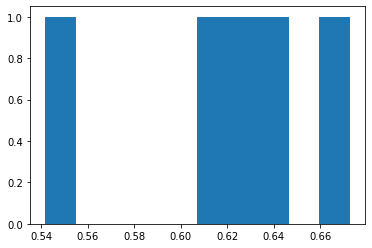

In [5]:
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import LinearSVC, SVC

from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, Bidirectional, Embedding, CuDNNGRU
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
import keras.backend as K
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping

eps = 1e-10
folds = 5

kfold = StratifiedKFold(n_splits=folds, shuffle=True)

cvscores = []

for train, test in kfold.split(X, y):
    #% Build a new model
    model = Sequential([
            Embedding(len(tokenizer.word_index) + 1, 64, input_length=sequence_length),
            CuDNNLSTM(64),
            Dense(1, activation='sigmoid')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X[train], y[train], epochs=50, batch_size=256, validation_data=(X[test], y[test]), callbacks=[early_stopping])
    
    y_pred = np.round(model.predict(X[test]))
    
    print('Classification report:', classification_report(y[test], y_pred))
    print('Confusion matrix :', confusion_matrix(y[test], y_pred))
    
    cm = confusion_matrix(y[test], y_pred)
    true_positive = cm[1][1]
    false_positive = cm[0][1]
    false_negative = cm[1][0]
    recall = true_positive / (true_positive + false_negative + eps)
    precision = true_positive / (true_positive + false_positive + eps)
    f1_score = 2 * recall * precision / (precision + recall + eps)
    print('Calculated f1 :', f1_score)
    print('Sklearn f1 :', classification_report(y[test], y_pred, output_dict=True)['1']['f1-score'])
    
    #% Get score
    scores = model.evaluate(X[test], y[test])
    cvscores.append(f1_score)

plt.hist(cvscores)
plt.show()